In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import ast # For parsing genres and other stringified lists
from collections import Counter # For multi-label genre/crew/cast analysis

Data Ingestion: Loading the final processed dataset from Phase 1 to begin the exploratory analysis phase.

In [ ]:
# --- Configure Plotting Style ---
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('viridis')

# --- Mount Google Drive and Define Paths ---
from google.colab import drive
drive.mount('/content/drive')

drive_path = '/content/drive/MyDrive/Embedding_Based_Recommendations_Project/Datasets/final_datasets/'
full_dataset_parquet_path = os.path.join(drive_path, 'multimodal_movies_full_dataset_for_publication.parquet')

Mounted at /content/drive


In [ ]:
# --- Load the Full Dataset ---
print(f"Loading full dataset from: {full_dataset_parquet_path}")
if not os.path.exists(full_dataset_parquet_path):
    print(f"Error: Full dataset Parquet file not found at {full_dataset_parquet_path}.")
    print("Please ensure you uploaded it from your local PC to this Drive path.")
    raise FileNotFoundError("Full dataset not found.")

try:
    full_movies_df = pd.read_parquet(full_dataset_parquet_path)
    print(f"Dataset loaded successfully. Shape: {full_movies_df.shape}")
    print("Columns:", full_movies_df.columns.tolist())
except Exception as e:
    print(f"Error loading Parquet file: {e}")
    raise

Loading full dataset from: /content/drive/MyDrive/Embedding_Based_Recommendations_Project/Datasets/final_datasets/multimodal_movies_full_dataset_for_publication.parquet
Dataset loaded successfully. Shape: (44600, 27)
Columns: ['tmdb_id', 'title', 'plot_description', 'genres', 'adult', 'tagline', 'director', 'writer', 'composer', 'cinematographer', 'editor', 'productiondesigner', 'artdirector', 'main_actors', 'crew_text_features', 'cast_text_features', 'original_language', 'runtime', 'vote_average', 'vote_count', 'release_date', 'popularity', 'budget', 'revenue', 'Poster_available', 'poster_byte', 'avg_rgb_color']


In [ ]:
def parse_list_column_corrected(list_str):
    if isinstance(list_str, str):
        try:
            # Safely evaluate the string as a Python literal (e.g., list of dicts)
            parsed_literal = ast.literal_eval(list_str)

            if isinstance(parsed_literal, list):
                extracted_items = []
                for item in parsed_literal:
                    if isinstance(item, dict) and 'name' in item:
                        # This handles the {'id': X, 'name': 'Y'} format
                        extracted_items.append(item['name'].strip())
                    elif isinstance(item, str):
                        # This handles cases where it might just be a list of strings
                        extracted_items.append(item.strip())
                return [item for item in extracted_items if item] # Filter out empty strings
            else: # If it's a single dictionary or other non-list type (e.g., from an error in original data)
                if isinstance(parsed_literal, dict) and 'name' in parsed_literal:
                    return [parsed_literal['name'].strip()]
        except (ValueError, SyntaxError):
            # Fallback for pipe-separated string (e.g., "Action|Comedy") if literal_eval fails
            return [g.strip() for g in list_str.split('|') if g.strip()]
    return [] # Return empty list for NaN, empty strings, or unparseable values

# --- Column Renaming for Consistency (if 'director' is present and not 'directors') ---
if 'director' in full_movies_df.columns and 'directors' not in full_movies_df.columns:
    full_movies_df.rename(columns={'director': 'directors'}, inplace=True)
    print("Renamed 'director' column to 'directors' for consistency.")


# --- Apply the corrected parsing to relevant columns ---
print("\nApplying corrected parsing to list-like columns...")
list_columns_to_parse = [
    'genres', 'directors', 'writer', 'composer', 'cinematographer', 'editor',
    'productiondesigner', 'artdirector', 'main_actors'
]

original_list_columns_to_drop = []

for col in list_columns_to_parse:
    if col in full_movies_df.columns:
        full_movies_df[f'{col}_parsed'] = full_movies_df[col].apply(parse_list_column_corrected)
        print(f"'{col}' column parsed. Sample: {full_movies_df[f'{col}_parsed'].head().tolist()}")
        original_list_columns_to_drop.append(col) # Mark original column for dropping
    else:
        print(f"Warning: Column '{col}' not found for parsing.")


# --- Remove Original Unparsed List Columns ---
print("\nRemoving original unparsed list columns...")
full_movies_df.drop(columns=original_list_columns_to_drop, inplace=True, errors='ignore')
print("Columns after dropping original list columns:", full_movies_df.columns.tolist())


Renamed 'director' column to 'directors' for consistency.

Applying corrected parsing to list-like columns...
'genres' column parsed. Sample: [['Animation', 'Comedy', 'Family'], ['Adventure', 'Fantasy', 'Family'], ['Romance', 'Comedy'], ['Comedy', 'Drama', 'Romance'], ['Comedy']]
'directors' column parsed. Sample: [['John Lasseter'], ['Joe Johnston'], ['Howard Deutch'], ['Forest Whitaker'], ['Charles Shyer']]
'writer' column parsed. Sample: [['Joss Whedon', 'Andrew Stanton', 'Joel Cohen', 'Alec Sokolow'], ['Jonathan Hensleigh', 'Greg Taylor', 'Jim Strain'], [], ['Ronald Bass', 'Terry McMillan'], ['Nancy Meyers', 'Albert Hackett']]
'composer' column parsed. Sample: [[], ['James Horner'], [], ['Kenneth Edmonds'], ['Alan Silvestri']]
'cinematographer' column parsed. Sample: [[], ['Thomas E. Ackerman'], [], [], ['Elliot Davis']]
'editor' column parsed. Sample: [['Lee Unkrich', 'Robert Gordon'], ['Robert Dalva'], [], [], ['Adam Bernardi']]
'productiondesigner' column parsed. Sample: [[], ['

**Initial Data Audit: Performing a high-level inspection of the DataFrame to review data types, memory usage, and the prevalence of null values across columns.**

In [ ]:
full_movies_df.info()


--- Basic Dataset Information ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44600 entries, 0 to 44599
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   tmdb_id                    44600 non-null  int64  
 1   title                      44597 non-null  object 
 2   plot_description           44600 non-null  object 
 3   adult                      44600 non-null  bool   
 4   tagline                    20433 non-null  object 
 5   crew_text_features         43829 non-null  object 
 6   cast_text_features         42258 non-null  object 
 7   original_language          44590 non-null  object 
 8   runtime                    44597 non-null  float64
 9   vote_average               44597 non-null  float64
 10  vote_count                 44597 non-null  float64
 11  release_date               44526 non-null  object 
 12  popularity                 44597 non-null  float64
 13  budget     

In [ ]:
full_movies_df.head()


First 5 rows:


,tmdb_id,title,plot_description,adult,tagline,crew_text_features,cast_text_features,original_language,runtime,vote_average,...,avg_rgb_color,genres_parsed,directors_parsed,writer_parsed,composer_parsed,cinematographer_parsed,editor_parsed,productiondesigner_parsed,artdirector_parsed,main_actors_parsed
0,862,Toy Story,"Led by Woody, Andy's toys live happily in his ...",False,None,Directed by John Lasseter. Written by Joss Whe...,"Starring Tom Hanks, Tim Allen, Don Rickles, Ji...",en,81.0,7.7,...,None,"[Animation, Comedy, Family]",[John Lasseter],"[Joss Whedon, Andrew Stanton, Joel Cohen, Alec...",[],[],"[Lee Unkrich, Robert Gordon]",[],[Ralph Eggleston],"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney..."
1,8844,Jumanji,When siblings Judy and Peter discover an encha...,False,Roll the dice and unleash the excitement!,Directed by Joe Johnston. Written by Jonathan ...,"Starring Robin Williams, Jonathan Hyde, Kirste...",en,104.0,6.9,...,"[137.4868927001953, 137.00750732421875, 132.45...","[Adventure, Fantasy, Family]",[Joe Johnston],"[Jonathan Hensleigh, Greg Taylor, Jim Strain]",[James Horner],[Thomas E. Ackerman],[Robert Dalva],[James D. Bissell],[],"[Robin Williams, Jonathan Hyde, Kirsten Dunst,..."
2,15602,Grumpier Old Men,A family wedding reignites the ancient feud be...,False,Still Yelling. Still Fighting. Still Ready for...,Directed by Howard Deutch.,"Starring Walter Matthau, Jack Lemmon, Ann-Marg...",en,101.0,6.5,...,None,"[Romance, Comedy]",[Howard Deutch],[],[],[],[],[],[],"[Walter Matthau, Jack Lemmon, Ann-Margret, Sop..."
3,31357,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",False,Friends are the people who let you be yourself...,Directed by Forest Whitaker. Written by Ronald...,"Starring Whitney Houston, Angela Bassett, Lore...",en,127.0,6.1,...,None,"[Comedy, Drama, Romance]",[Forest Whitaker],"[Ronald Bass, Terry McMillan]",[Kenneth Edmonds],[],[],[],[],"[Whitney Houston, Angela Bassett, Loretta Devi..."
4,11862,Father of the Bride Part II,Just when George Banks has recovered from his ...,False,Just When His World Is Back To Normal... He's ...,Directed by Charles Shyer. Written by Nancy Me...,"Starring Steve Martin, Diane Keaton, Martin Sh...",en,106.0,5.7,...,None,[Comedy],[Charles Shyer],"[Nancy Meyers, Albert Hackett]",[Alan Silvestri],[Elliot Davis],[Adam Bernardi],[],[],"[Steve Martin, Diane Keaton, Martin Short, Kim..."


**Summary Statistics: Generating descriptive statistics for the numerical features to understand their central tendency, dispersion, and scale.**

In [ ]:
full_movies_df.describe()


Descriptive statistics for numerical columns:


,tmdb_id,runtime,vote_average,vote_count,popularity,budget,revenue
count,44600.000000,44597.000000,44597.000000,44597.000000,44597.000000,4.460000e+04,4.459700e+04
mean,106875.568700,94.964661,5.639274,111.922551,2.972086,4.308256e+06,1.143231e+07
std,111762.442424,37.566475,1.896709,495.823277,6.053733,1.758442e+07,6.493424e+07
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00
25%,25902.750000,85.000000,5.000000,3.000000,0.404641,0.000000e+00,0.000000e+00
50%,58519.500000,95.000000,6.000000,10.000000,1.161030,0.000000e+00,0.000000e+00
75%,152999.250000,107.000000,6.800000,35.000000,3.803547,0.000000e+00,0.000000e+00
max,469172.000000,1256.000000,10.000000,14075.000000,547.488298,3.800000e+08,2.787965e+09


In [ ]:
missing_data = full_movies_df.isnull().sum()
missing_percentage = (full_movies_df.isnull().sum() / len(full_movies_df)) * 100
missing_df = pd.DataFrame({'Missing Count': missing_data, 'Missing Percentage (%)': missing_percentage})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values(by='Missing Count', ascending=False)
missing_df


--- Missing Values Analysis ---


,Missing Count,Missing Percentage (%)
poster_byte,38964,87.363229
avg_rgb_color,38964,87.363229
tagline,24167,54.186099
cast_text_features,2342,5.251121
crew_text_features,771,1.728700
release_date,74,0.165919
original_language,10,0.022422
title,3,0.006726
runtime,3,0.006726
vote_count,3,0.006726



--- 'Poster_available' Flag Distribution ---
                  Count  Percentage (%)
Poster_available                       
False             38964       87.363229
True               5636       12.636771


/tmp/ipython-input-8-1468272769.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=poster_available_counts.index, y=poster_available_counts.values, palette=['skyblue', 'lightcoral'])


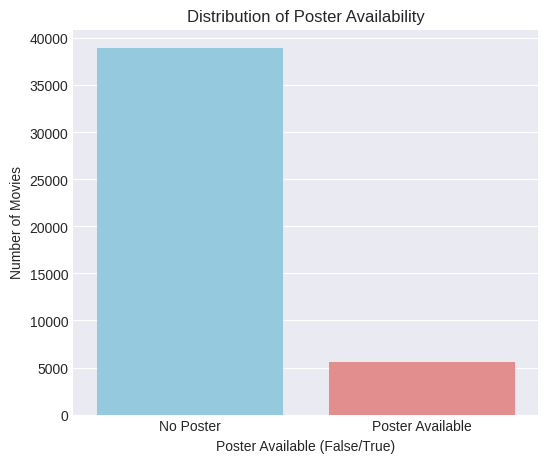

In [ ]:
if 'Poster_available' in full_movies_df.columns:
    poster_available_counts = full_movies_df['Poster_available'].value_counts()
    poster_available_percentage = full_movies_df['Poster_available'].value_counts(normalize=True) * 100
    print(pd.DataFrame({'Count': poster_available_counts, 'Percentage (%)': poster_available_percentage}))

    plt.figure(figsize=(6, 5))
    sns.barplot(x=poster_available_counts.index, y=poster_available_counts.values, palette=['skyblue', 'lightcoral'])
    plt.title('Distribution of Poster Availability')
    plt.xlabel('Poster Available (False/True)')
    plt.ylabel('Number of Movies')
    plt.xticks(ticks=[0, 1], labels=['No Poster', 'Poster Available'])
    plt.show()
else:
    print("'Poster_available' column not found.")


--- Release Year Distribution ---
Min Release Year: 1874
Max Release Year: 2020
Median Release Year: 2001.0
Mean Release Year: 1991.80


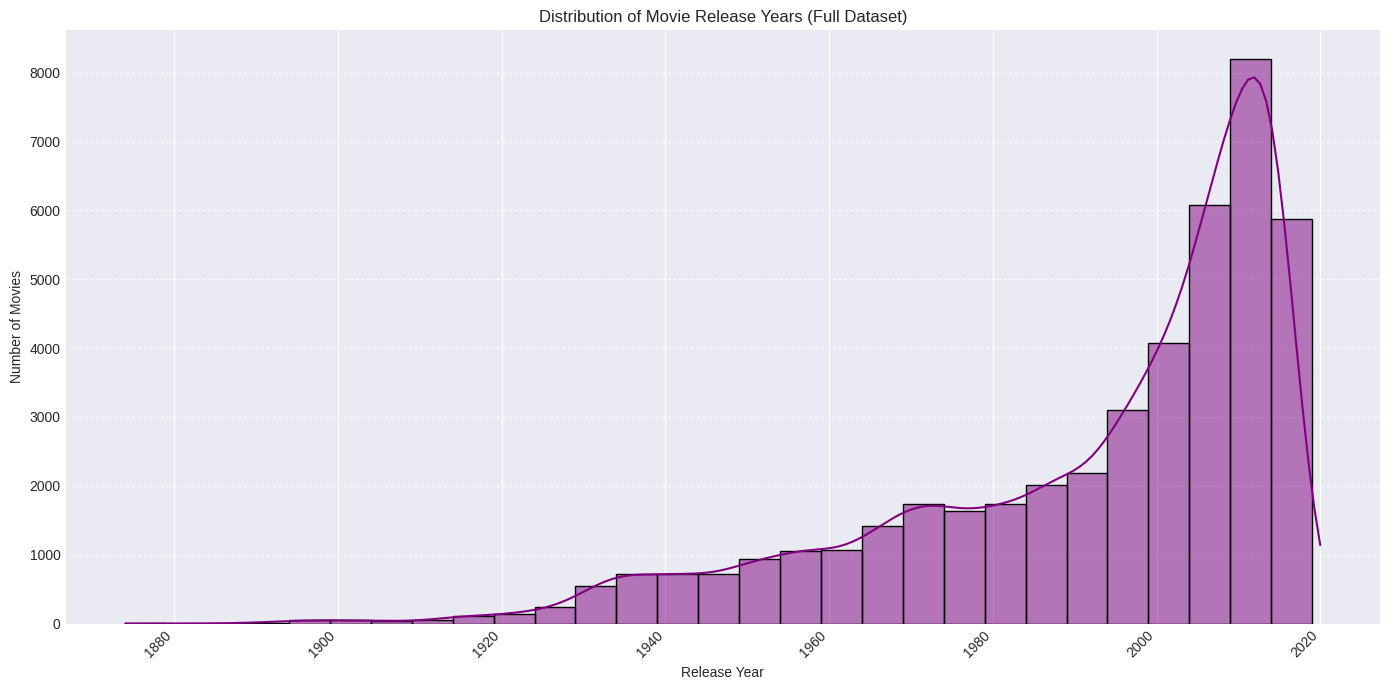

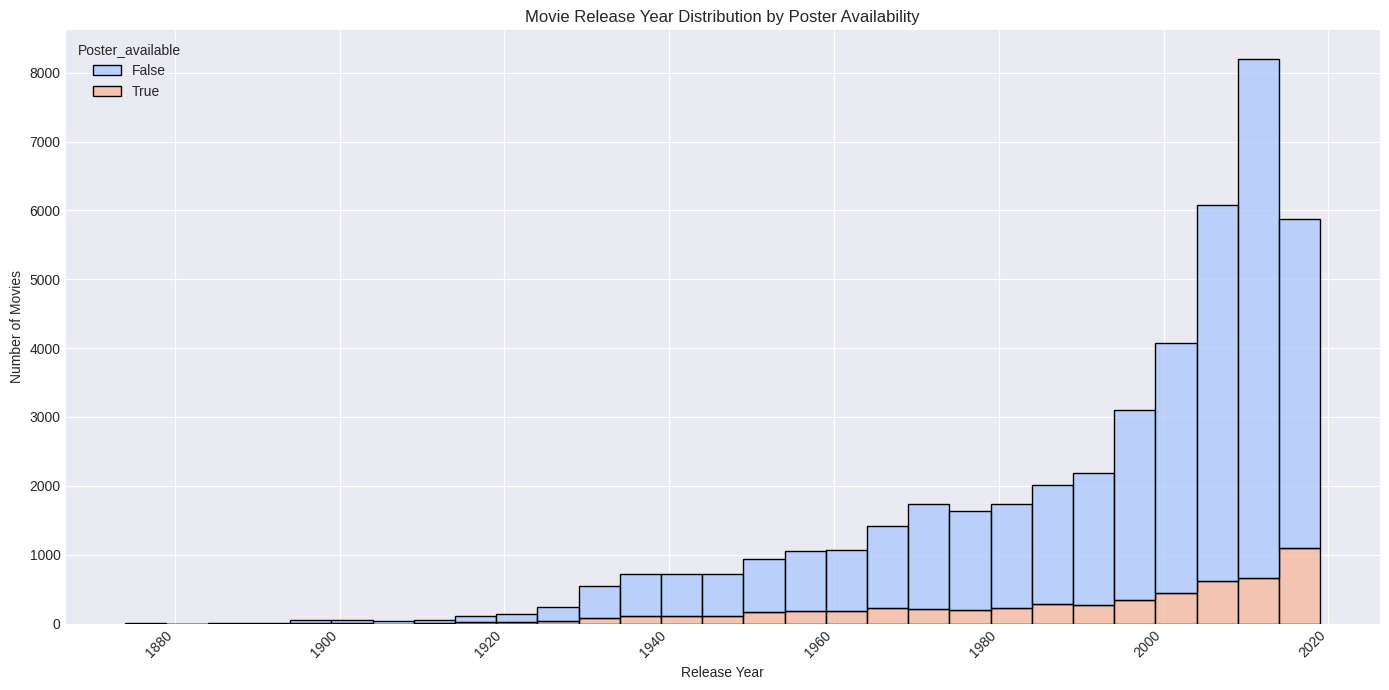

In [ ]:
print("\n--- Release Year Distribution ---")
if 'release_date' in full_movies_df.columns:
    full_movies_df['release_date_dt'] = pd.to_datetime(full_movies_df['release_date'], errors='coerce')
    full_movies_df['release_year'] = full_movies_df['release_date_dt'].dt.year.astype('Int64') # Use Int64 to allow NaN

    release_years = full_movies_df.dropna(subset=['release_year'])['release_year']
    if not release_years.empty:
        print(f"Min Release Year: {release_years.min()}")
        print(f"Max Release Year: {release_years.max()}")
        print(f"Median Release Year: {release_years.median()}")
        print(f"Mean Release Year: {release_years.mean():.2f}")

        plt.figure(figsize=(14, 7))
        sns.histplot(release_years, bins=range(int(release_years.min()), int(release_years.max()) + 2, 5), kde=True, color='purple')
        plt.title('Distribution of Movie Release Years (Full Dataset)')
        plt.xlabel('Release Year')
        plt.ylabel('Number of Movies')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

        # Release Year vs Poster Availability
        if 'Poster_available' in full_movies_df.columns:
            plt.figure(figsize=(14, 7))
            sns.histplot(data=full_movies_df, x='release_year', hue='Poster_available', bins=range(int(release_years.min()), int(release_years.max()) + 2, 5), multiple='stack', palette='coolwarm')
            plt.title('Movie Release Year Distribution by Poster Availability')
            plt.xlabel('Release Year')
            plt.ylabel('Number of Movies')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()
    else:
        print("No valid release year data to plot.")
else:
    print("'release_date' column not found.")


--- Genre Distribution (Top 20 Primary and Multi-label) ---
Primary Genre Distribution (Top 20):
primary_genre
Drama              0.265561
Comedy             0.191166
Action             0.100269
Documentary        0.075807
Horror             0.058587
Unknown            0.049036
Crime              0.037399
Thriller           0.037063
Adventure          0.033901
Romance            0.026099
Animation          0.025000
Fantasy            0.015673
Science Fiction    0.014327
Mystery            0.012265
Family             0.011390
Music              0.010762
Western            0.010067
TV Movie           0.008543
War                0.008363
History            0.006121
Name: proportion, dtype: float64


/tmp/ipython-input-10-2975175958.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=primary_genre_dist.index, y=primary_genre_dist.values, palette='crest')


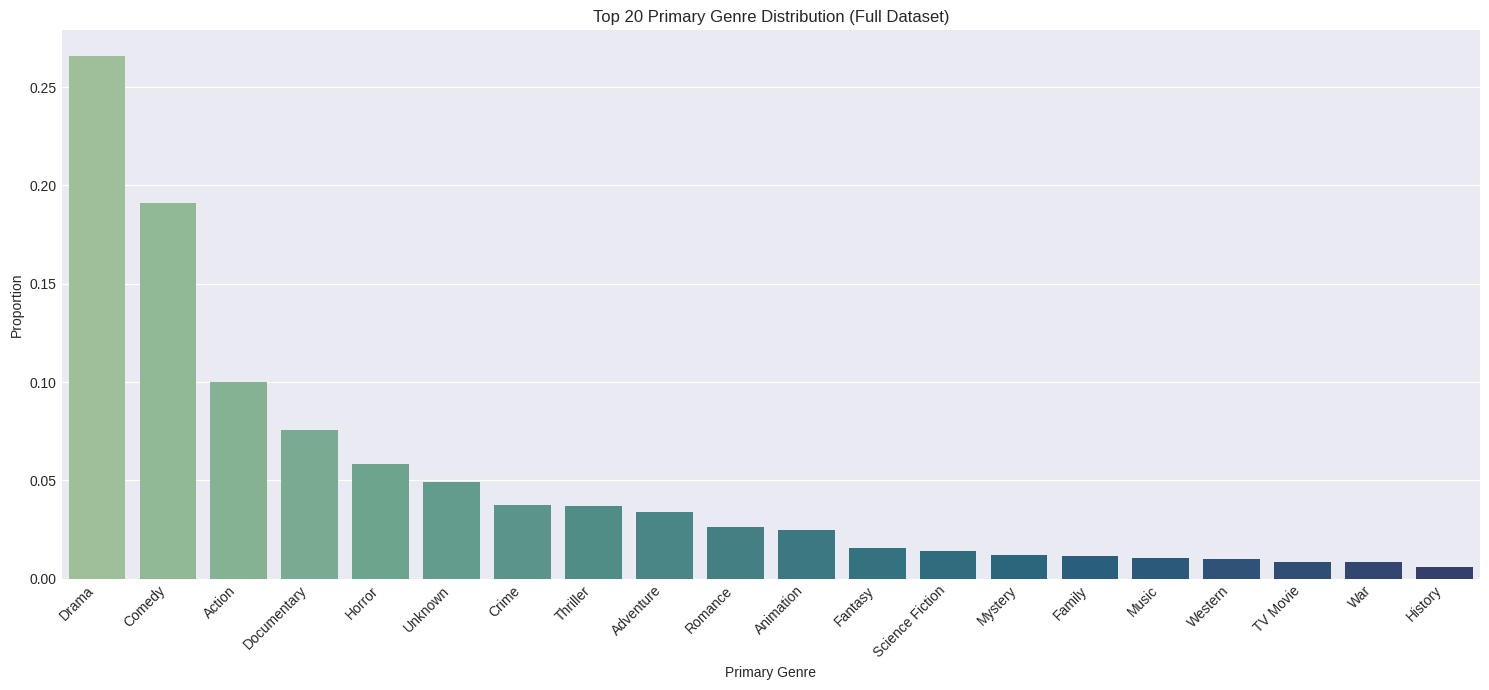


Multi-label Genre Distribution (Top 20):
              Genre  Count
0             Drama  20084
1            Comedy  12820
2          Thriller   7602
3           Romance   6684
4            Action   6576
5            Horror   4666
6             Crime   4290
7       Documentary   3891
8         Adventure   3482
9   Science Fiction   3040
10           Family   2738
11          Mystery   2473
12          Fantasy   2299
13        Animation   1930
14          Foreign   1605
15            Music   1590
16          History   1379
17              War   1312
18          Western   1035
19         TV Movie    753


/tmp/ipython-input-10-2975175958.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Genre', y='Count', data=genre_counts_multi_df, palette='magma')


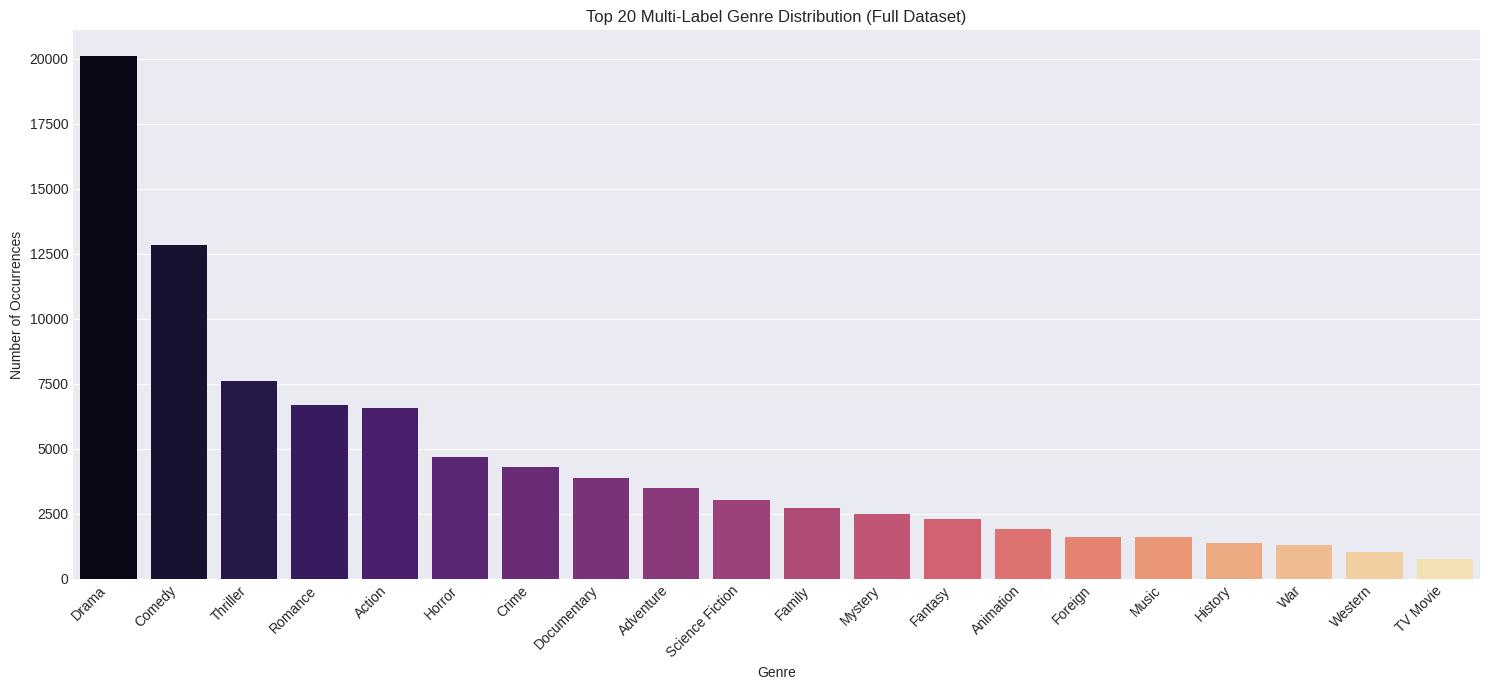

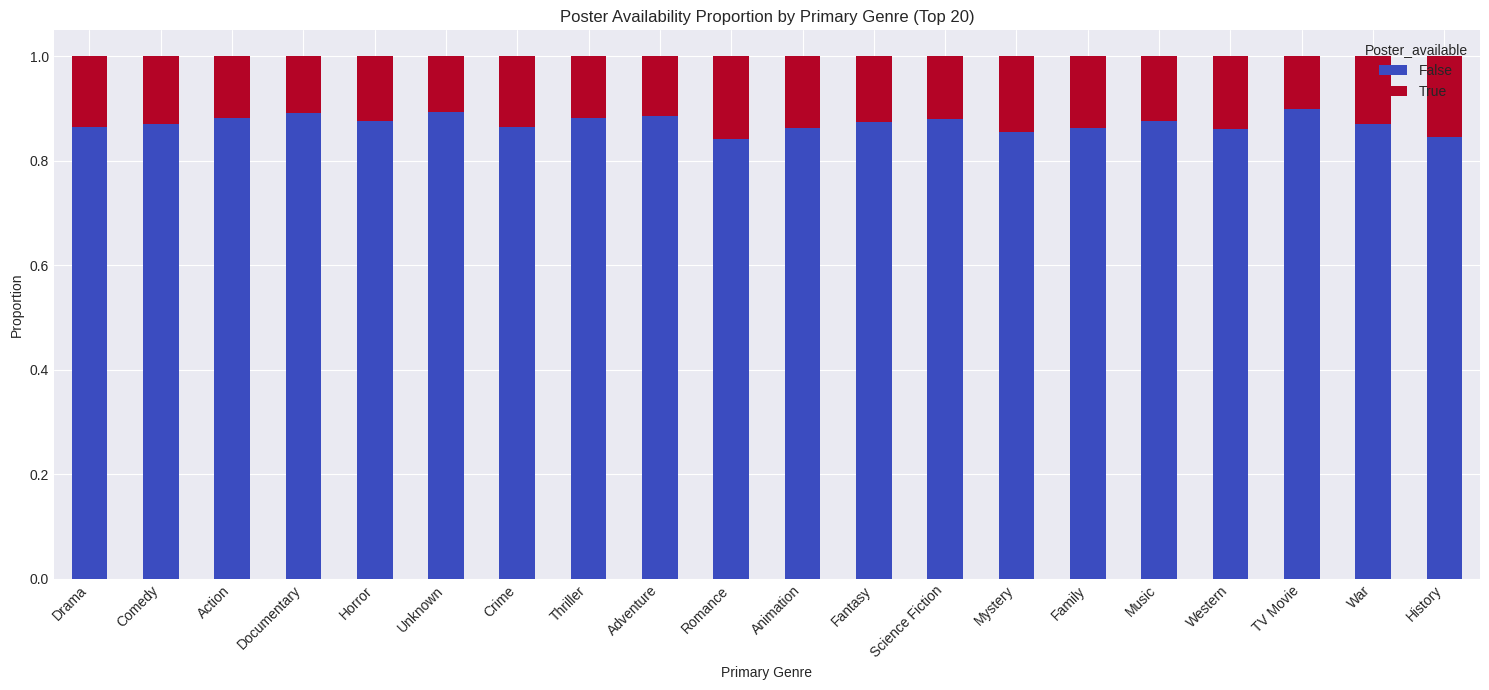

In [ ]:
print("\n--- Genre Distribution (Top 20 Primary and Multi-label) ---")
if 'genres_parsed' in full_movies_df.columns:
    full_movies_df['primary_genre'] = full_movies_df['genres_parsed'].apply(lambda x: x[0] if x else 'Unknown')

    if not full_movies_df['primary_genre'].empty:
        primary_genre_dist = full_movies_df['primary_genre'].value_counts(normalize=True).head(20)
        print("Primary Genre Distribution (Top 20):")
        print(primary_genre_dist)
        plt.figure(figsize=(15, 7))
        sns.barplot(x=primary_genre_dist.index, y=primary_genre_dist.values, palette='crest')
        plt.title('Top 20 Primary Genre Distribution (Full Dataset)')
        plt.xlabel('Primary Genre')
        plt.ylabel('Proportion')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    else:
        print("No valid primary genre data to plot.")

    # Multi-label Genre Distribution
    all_genres = [genre for sublist in full_movies_df['genres_parsed'] if sublist for genre in sublist] # Ensure sublist is not empty
    genre_counts_multi = Counter(all_genres)
    genre_counts_multi_df = pd.DataFrame(genre_counts_multi.most_common(20), columns=['Genre', 'Count'])
    print("\nMulti-label Genre Distribution (Top 20):")
    print(genre_counts_multi_df)
    plt.figure(figsize=(15, 7))
    sns.barplot(x='Genre', y='Count', data=genre_counts_multi_df, palette='magma')
    plt.title('Top 20 Multi-Label Genre Distribution (Full Dataset)')
    plt.xlabel('Genre')
    plt.ylabel('Number of Occurrences')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Poster Availability by Primary Genre
    if 'Poster_available' in full_movies_df.columns and not full_movies_df['primary_genre'].empty:
        genre_poster_availability = full_movies_df.groupby('primary_genre')['Poster_available'].value_counts(normalize=True).unstack(fill_value=0)

        top_genres_for_plot = primary_genre_dist.index.tolist()
        if not top_genres_for_plot: # Handle case where primary_genre_dist is empty
            print("Not enough top genres to plot availability by genre.")
        else:
            genre_poster_availability_plot = genre_poster_availability.reindex(top_genres_for_plot, fill_value=0)

            genre_poster_availability_plot.plot(kind='bar', stacked=True, figsize=(15, 7), colormap='coolwarm')
            plt.title('Poster Availability Proportion by Primary Genre (Top 20)')
            plt.xlabel('Primary Genre')
            plt.ylabel('Proportion')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()
else:
    print("'genres' or 'genres_parsed' column not found.")




--- Original Language Distribution (Top 15) ---
original_language
en    0.723548
fr    0.051200
ja    0.030343
it    0.028370
de    0.021642
es    0.020722
ru    0.017582
hi    0.011348
ko    0.009957
zh    0.009128
sv    0.008275
cn    0.007020
pt    0.006616
fi    0.005225
nl    0.005068
Name: proportion, dtype: float64


/tmp/ipython-input-11-2239097263.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=lang_dist.index, y=lang_dist.values, palette='cubehelix')


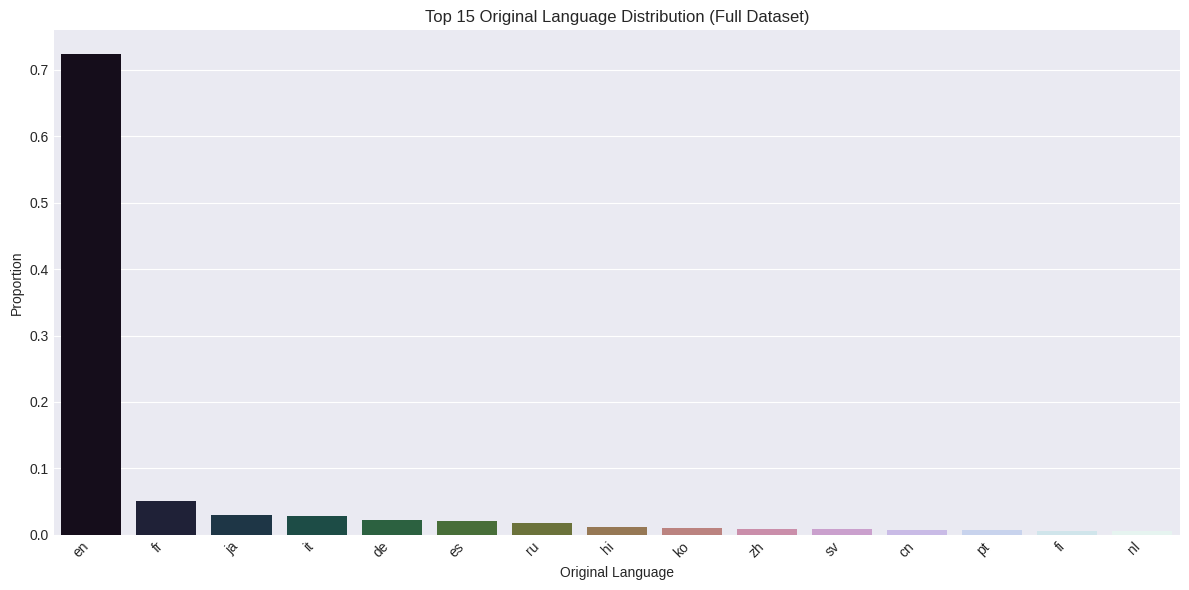

In [ ]:
print("\n--- Original Language Distribution (Top 15) ---")
if 'original_language' in full_movies_df.columns:
    lang_dist = full_movies_df['original_language'].value_counts(normalize=True).head(15)
    print(lang_dist)
    plt.figure(figsize=(12, 6))
    sns.barplot(x=lang_dist.index, y=lang_dist.values, palette='cubehelix')
    plt.title('Top 15 Original Language Distribution (Full Dataset)')
    plt.xlabel('Original Language')
    plt.ylabel('Proportion')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("'original_language' column not found.")


--- 'adult' Content Distribution ---
       Count  Percentage (%)
adult                       
False  44591       99.979821
True       9        0.020179


/tmp/ipython-input-12-1625704373.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=adult_counts.index, y=adult_counts.values, palette='pastel')


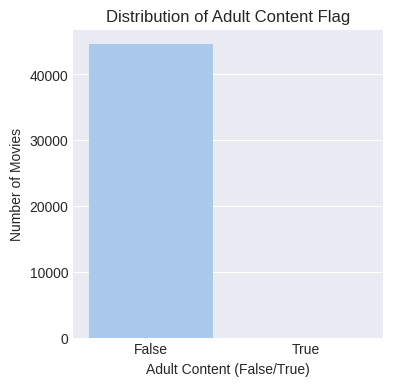

In [ ]:
print("\n--- 'adult' Content Distribution ---")
if 'adult' in full_movies_df.columns:
    adult_counts = full_movies_df['adult'].value_counts()
    adult_percentage = full_movies_df['adult'].value_counts(normalize=True) * 100
    print(pd.DataFrame({'Count': adult_counts, 'Percentage (%)': adult_percentage}))

    plt.figure(figsize=(4, 4))
    sns.barplot(x=adult_counts.index, y=adult_counts.values, palette='pastel')
    plt.title('Distribution of Adult Content Flag')
    plt.xlabel('Adult Content (False/True)')
    plt.ylabel('Number of Movies')
    plt.show()
else:
    print("'adult' column not found.")


--- Numerical Feature Distributions ---


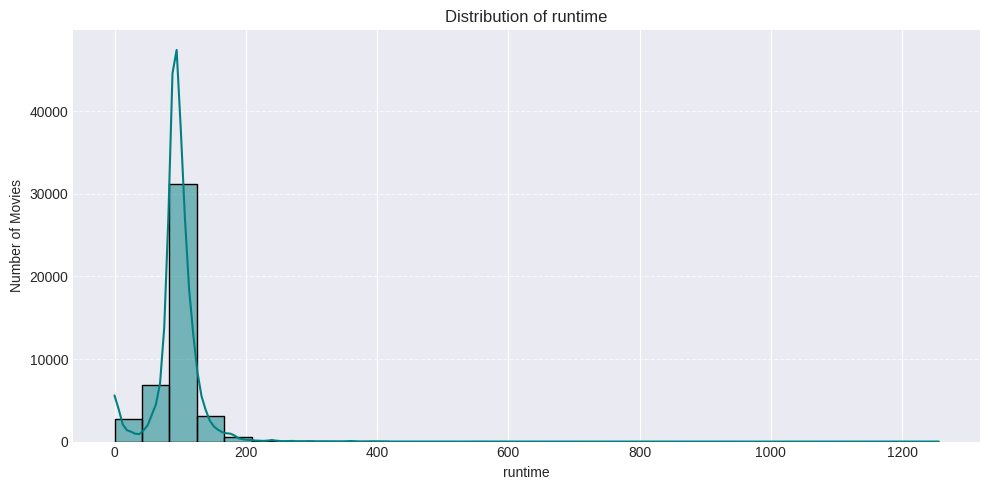

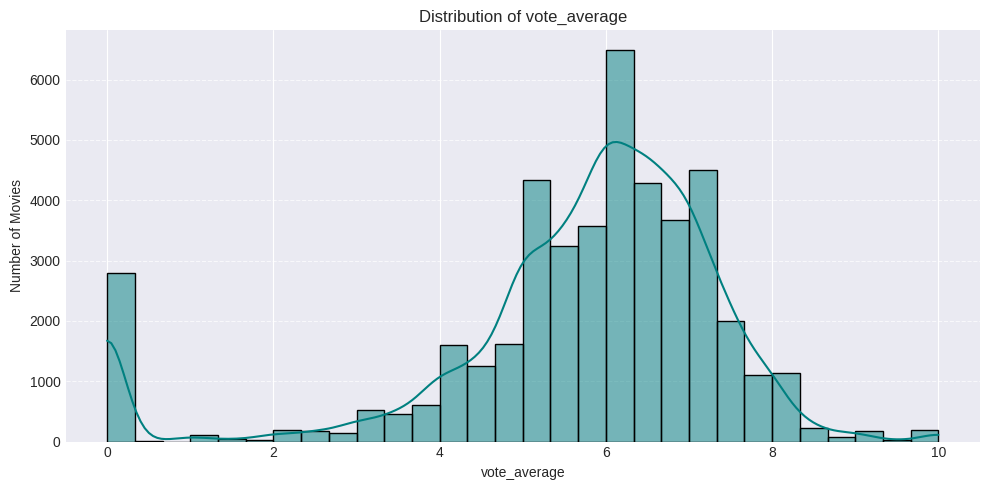

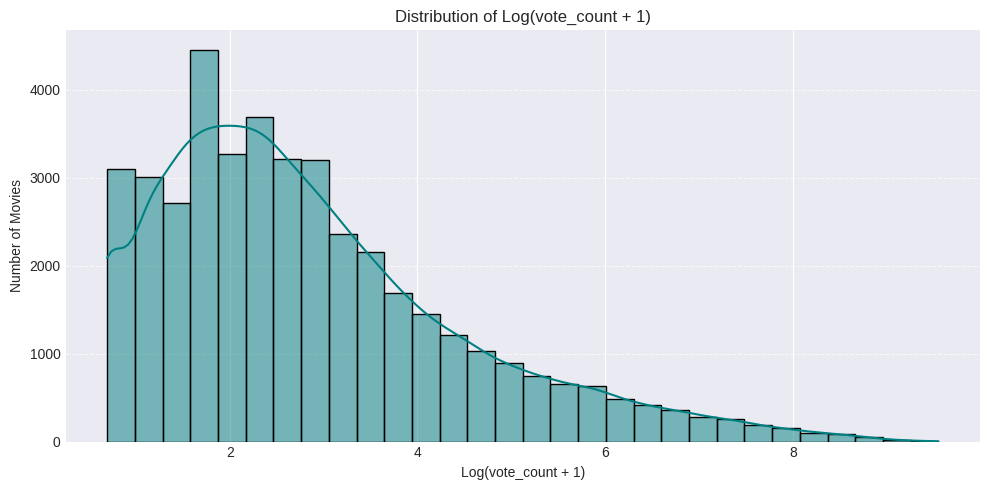

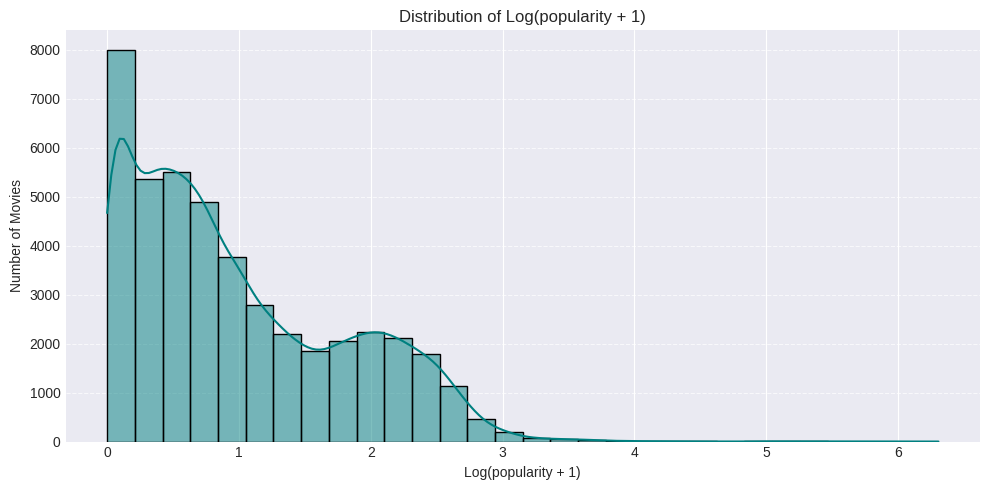

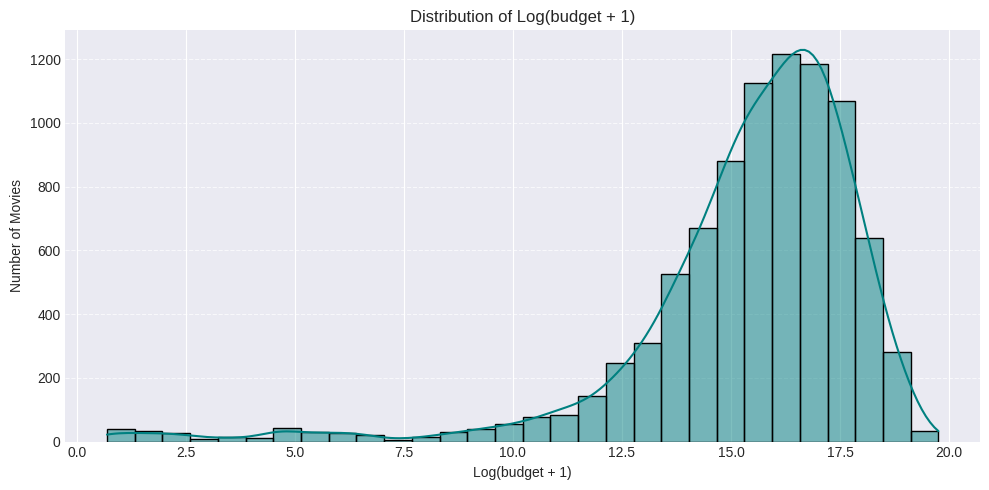

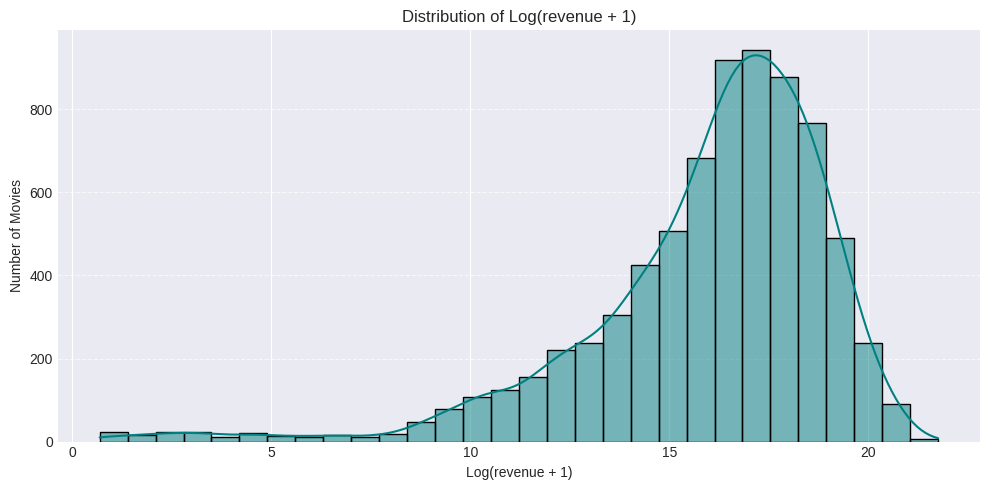

In [ ]:
print("\n--- Numerical Feature Distributions ---")
numerical_cols = ['runtime', 'vote_average', 'vote_count', 'popularity', 'budget', 'revenue']

for col in numerical_cols:
    if col in full_movies_df.columns:
        plt.figure(figsize=(10, 5))
        data_to_plot = full_movies_df[col].dropna()

        if data_to_plot.empty:
            print(f"Skipping plot for '{col}' as no valid numerical data found.")
            plt.close()
            continue

        # For budget/revenue/vote_count/popularity, log1p transform
        if col in ['vote_count', 'popularity', 'budget', 'revenue']:
            # Filter out zeros or very small values before log transform to avoid issues
            data_to_plot = data_to_plot[data_to_plot > 0]
            if not data_to_plot.empty:
                data_to_plot = np.log1p(data_to_plot)
                col_title = f'Log({col} + 1)'
            else:
                print(f"Skipping plot for '{col}' as all values are zero or non-positive after filtering.")
                plt.close()
                continue
        else:
            col_title = col

        sns.histplot(data_to_plot, bins=30, kde=True, color='teal')
        plt.title(f'Distribution of {col_title}')
        plt.xlabel(col_title)
        plt.ylabel('Number of Movies')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
    else:
        print(f"Column '{col}' not found in DataFrame.")


--- Top Directors, Writers, Composers, etc. Analysis ---

Top 20 Directors:
                  Name  Count
0            John Ford     68
1       Michael Curtiz     65
2        Werner Herzog     55
3     Alfred Hitchcock     53
4       Georges Méliès     51
5      Jean-Luc Godard     50
6          Woody Allen     49
7         Sidney Lumet     46
8    Steven Soderbergh     44
9      Charlie Chaplin     44
10  William A. Wellman     43
11      Henry Hathaway     43
12         Raoul Walsh     43
13        George Cukor     42
14      Richard Thorpe     42
15     Martin Scorsese     41
16         Frank Capra     39
17         John Huston     39
18      Ingmar Bergman     39
19       Robert Altman     38


/tmp/ipython-input-14-811273358.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Name', y='Count', data=top_names_df, palette='cividis')


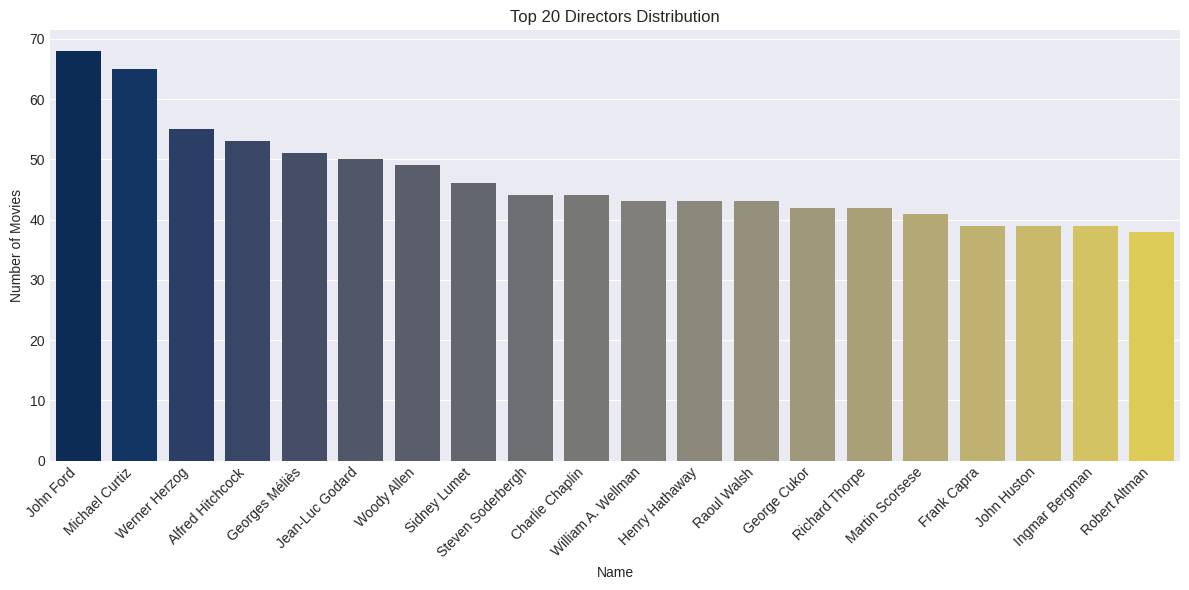


Top 15 Writer:
                    Name  Count
0              Ben Hecht     35
1            Woody Allen     33
2       Ernesto Gastaldi     30
3         Dudley Nichols     29
4       Nunnally Johnson     29
5      Julius J. Epstein     28
6           Billy Wilder     26
7         John Lee Mahin     24
8             Luc Besson     23
9    Suso Cecchi d'Amico     23
10          Lamar Trotti     23
11        Claude Chabrol     23
12        Albert Hackett     22
13  Jean-Claude Carrière     21
14           John Hughes     21


/tmp/ipython-input-14-811273358.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Name', y='Count', data=top_names_df, palette='cividis')


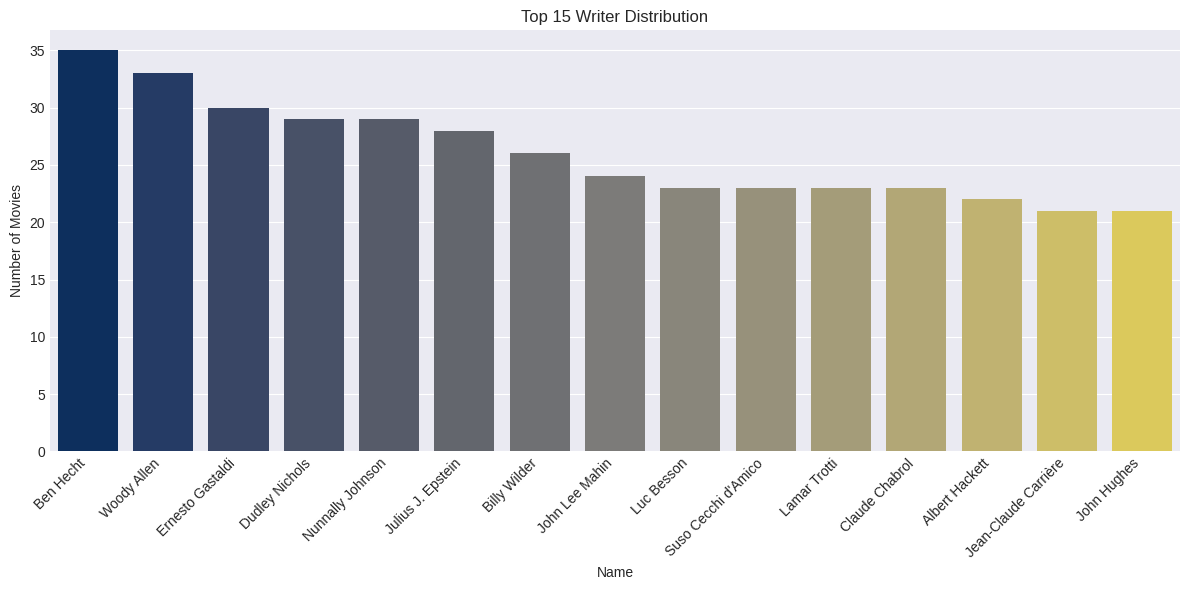


Top 15 Composer:
                   Name  Count
0           Max Steiner    145
1       Jerry Goldsmith    138
2       Ennio Morricone    114
3         Alfred Newman    104
4   James Newton Howard    100
5          James Horner     98
6           Hans Zimmer     92
7       Elmer Bernstein     86
8         Lalo Schifrin     85
9         John Williams     80
10         Franz Waxman     77
11             Roy Webb     72
12         Danny Elfman     69
13      Christophe Beck     68
14           Mark Isham     61


/tmp/ipython-input-14-811273358.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Name', y='Count', data=top_names_df, palette='cividis')


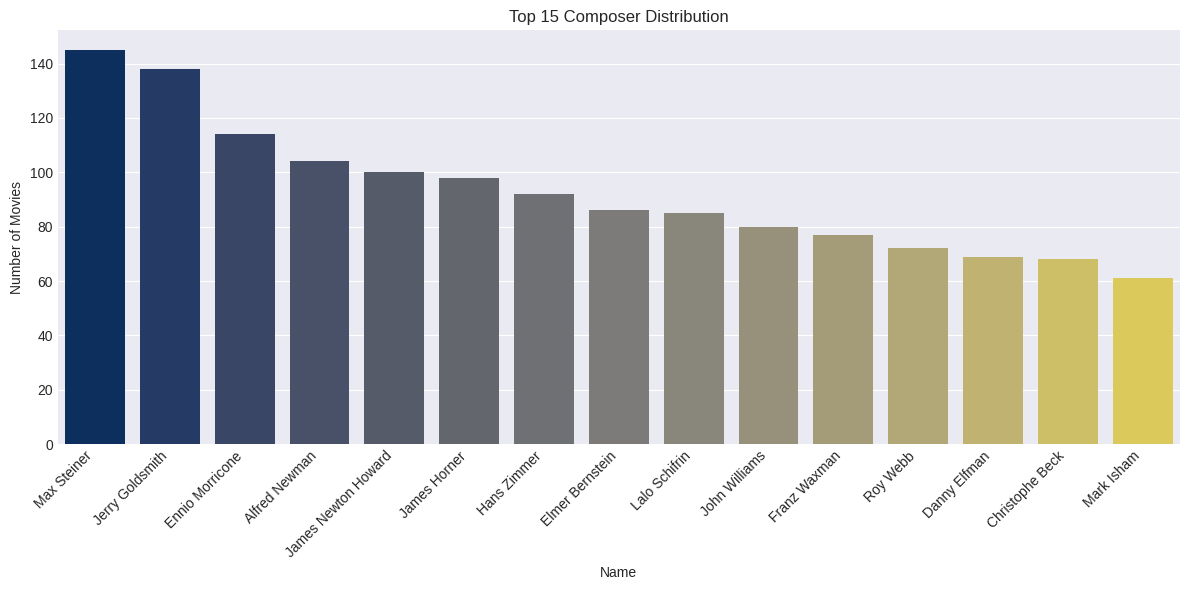


Top 15 Cinematographer:
                   Name  Count
0          Charles Lang     80
1   Harry Stradling Sr.     66
2    William H. Daniels     65
3       James Wong Howe     58
4       Joseph F. Biroc     54
5        Lucien Ballard     52
6            Sol Polito     51
7         Roger Deakins     50
8      Victor J. Kemper     50
9            Mark Irwin     49
10             Ray June     48
11       Burnett Guffey     48
12      Vilmos Zsigmond     47
13         Leon Shamroy     47
14    Nicholas Musuraca     46


/tmp/ipython-input-14-811273358.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Name', y='Count', data=top_names_df, palette='cividis')


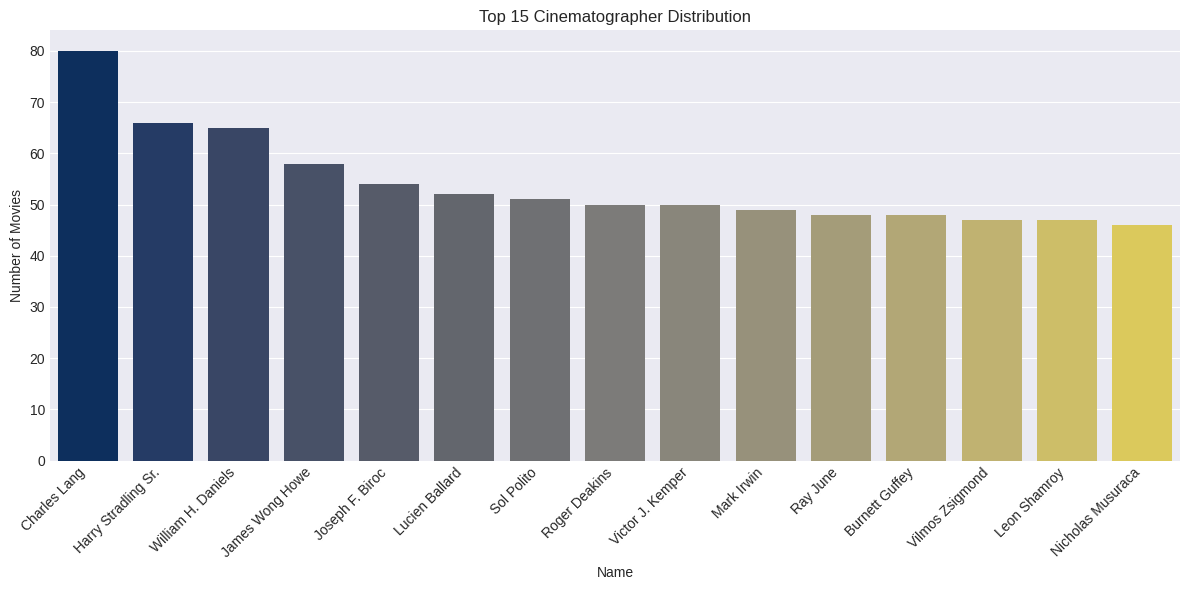


Top 15 Editor:
                 Name  Count
0        Michael Kahn     53
1   Chiang Hsing-Lung     52
2     Eugenio Alabiso     45
3      Anne V. Coates     40
4      Chris Lebenzon     37
5    William Reynolds     36
6        David Finfer     34
7     Dorothy Spencer     34
8      Ferris Webster     34
9     Mario Serandrei     34
10     Susan E. Morse     33
11    Carol Littleton     33
12           Joel Cox     32
13     Daniel Mandell     32
14        Paul Hirsch     31


/tmp/ipython-input-14-811273358.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Name', y='Count', data=top_names_df, palette='cividis')


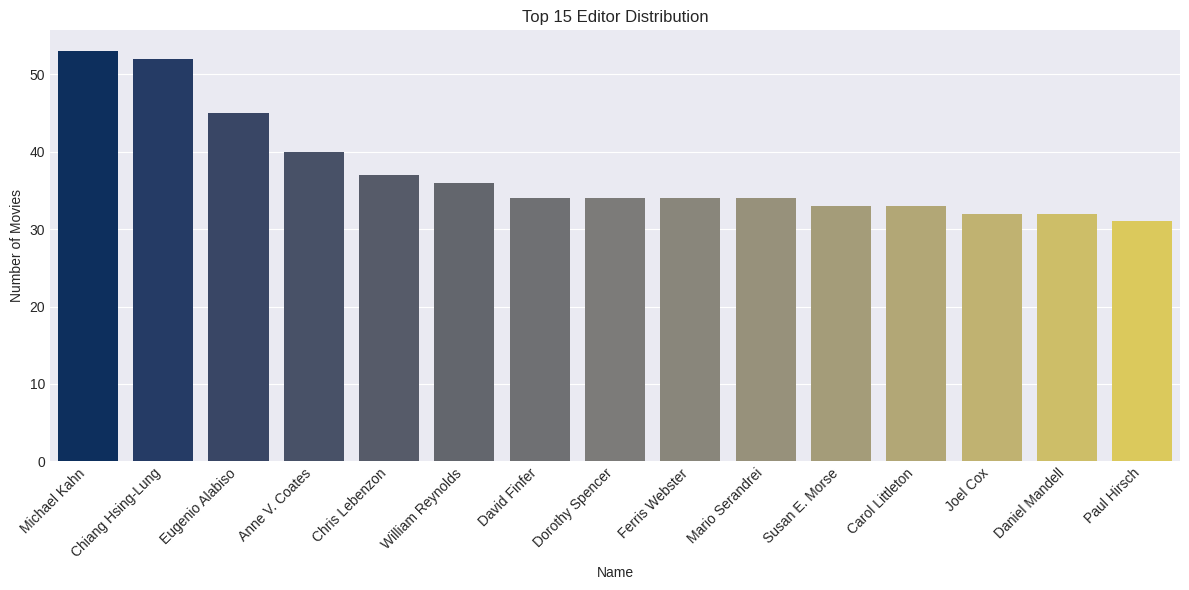


Top 15 Productiondesigner:
                         Name  Count
0              Santo Loquasto     32
1                Stuart Craig     28
2                    Jim Clay     27
3            Bernard Robinson     27
4             Richard Sylbert     26
5             J. Michael Riva     24
6              Dante Ferretti     23
7                 Carol Spier     23
8              Albert Brenner     23
9   Patrizia von Brandenstein     23
10              Terence Marsh     23
11           James D. Bissell     22
12              David Gropman     22
13                 Jon Hutman     22
14             Henry Bumstead     22


/tmp/ipython-input-14-811273358.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Name', y='Count', data=top_names_df, palette='cividis')


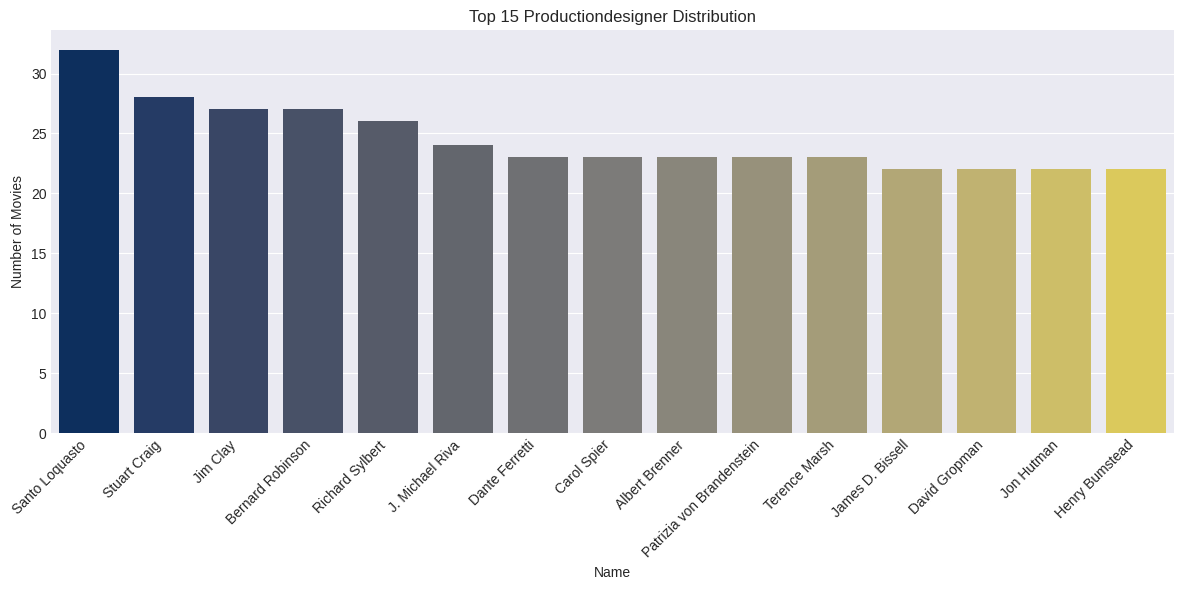


Top 15 Artdirector:
                    Name  Count
0         Cedric Gibbons    244
1            Hans Dreier    113
2        Lyle R. Wheeler    100
3            Richard Day     85
4            Hal Pereira     73
5   Albert S. D'Agostino     73
6      Van Nest Polglase     70
7     Alexander Golitzen     61
8         Robert M. Haas     47
9              Jack Okey     45
10     Jack Martin Smith     41
11       George W. Davis     39
12            Anton Grot     38
13         Carroll Clark     36
14       Roland Anderson     34


/tmp/ipython-input-14-811273358.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Name', y='Count', data=top_names_df, palette='cividis')


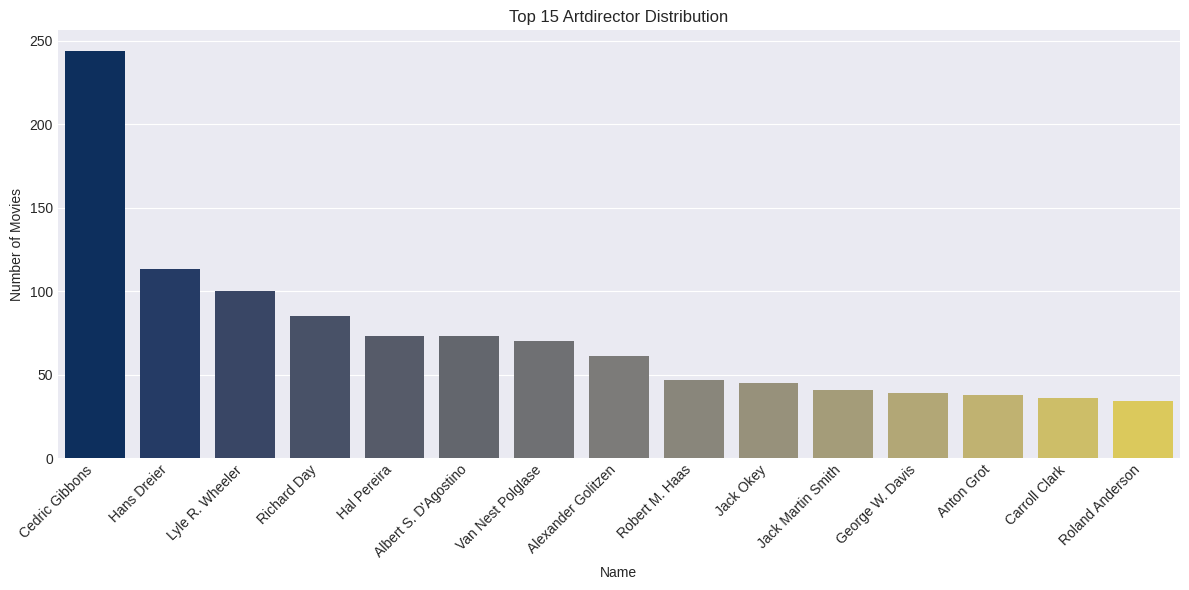


Top 20 Main Actors:
                  Name  Count
0           John Wayne    106
1          Jackie Chan    101
2      Christopher Lee     97
3       Robert De Niro     96
4        Michael Caine     96
5     Gérard Depardieu     94
6    Samuel L. Jackson     84
7    Donald Sutherland     82
8        Harvey Keitel     80
9         Danny Glover     78
10        Nicolas Cage     76
11        Bruce Willis     73
12      Susan Sarandon     73
13        Gene Hackman     72
14  Christopher Walken     72
15        Alec Baldwin     70
16           John Hurt     70
17        Eric Roberts     70
18         James Mason     70
19         Bette Davis     70


/tmp/ipython-input-14-811273358.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Name', y='Count', data=top_names_df, palette='cividis')


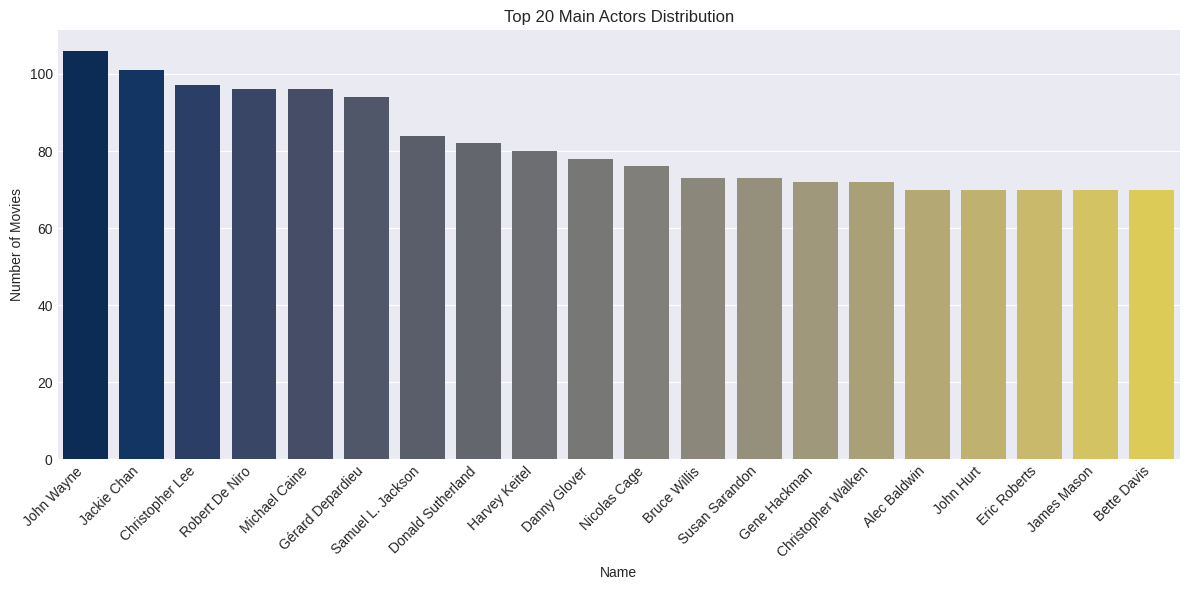

In [ ]:
rich_text_cols = [
    'directors_parsed', 'writer_parsed', 'composer_parsed', 'cinematographer_parsed',
    'editor_parsed', 'productiondesigner_parsed', 'artdirector_parsed', 'main_actors_parsed'
]

for col in rich_text_cols:
    if col in full_movies_df.columns:
        all_names = [name for sublist in full_movies_df[col] if sublist for name in sublist] # Ensure sublist is not empty
        name_counts = Counter(all_names)

        top_n = 20 if col in ['main_actors_parsed', 'directors_parsed'] else 15
        top_names_df = pd.DataFrame(name_counts.most_common(top_n), columns=['Name', 'Count'])

        if not top_names_df.empty:
            print(f"\nTop {top_n} {col.replace('_parsed', '').replace('_', ' ').title()}:")
            print(top_names_df)

            plt.figure(figsize=(12, 6))
            sns.barplot(x='Name', y='Count', data=top_names_df, palette='cividis')
            plt.title(f'Top {top_n} {col.replace("_parsed", "").replace("_", " ").title()} Distribution')
            plt.xlabel('Name')
            plt.ylabel('Number of Movies')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()
        else:
            print(f"No valid data found for Top {col.replace('_parsed', '').replace('_', ' ').title()}.")
    else:
        print(f"Column '{col}' not found in DataFrame.")



--- Text Feature Lengths ---


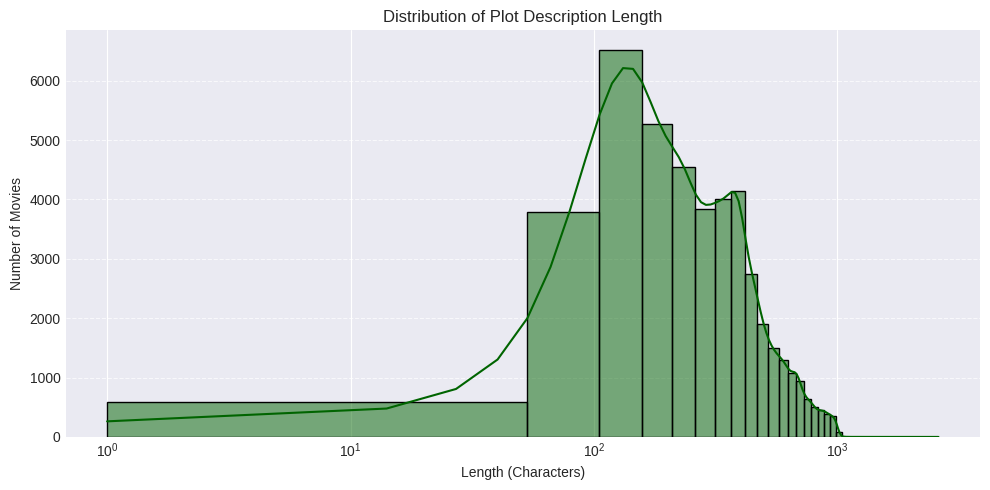

Average Plot Description Length: 324.22


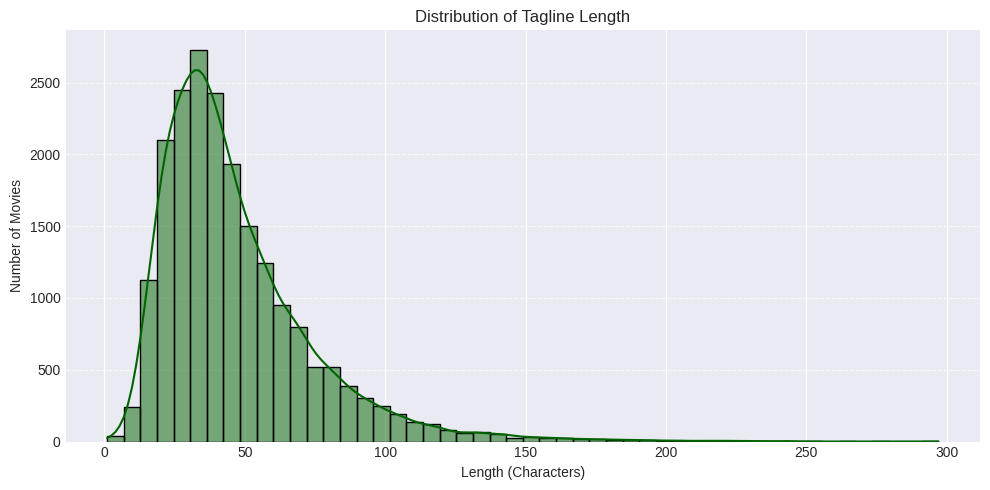

Average Tagline Length: 47.01


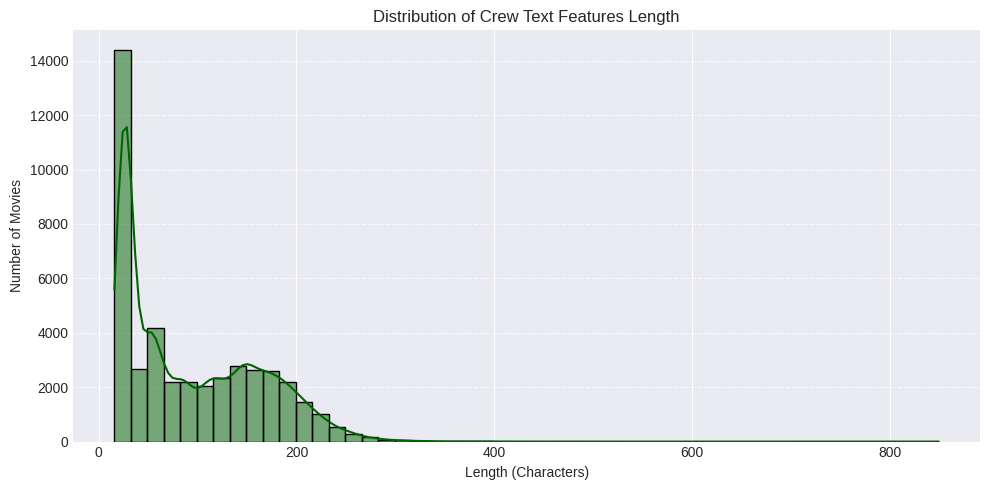

Average Crew Text Features Length: 93.55


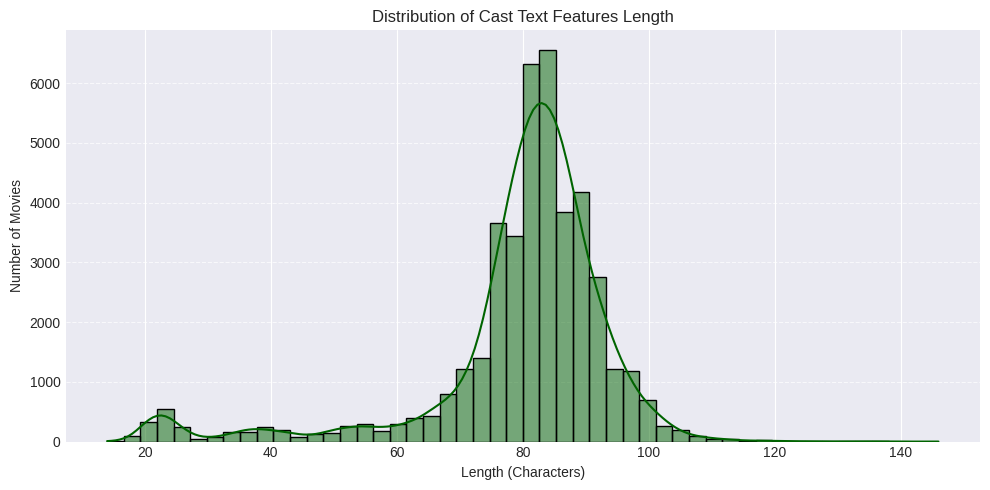

Average Cast Text Features Length: 79.76


In [ ]:
text_content_cols = ['plot_description', 'tagline', 'crew_text_features', 'cast_text_features']

for col in text_content_cols:
    if col in full_movies_df.columns:
        # Calculate length of string (handle NaN by filling with empty string for length calc)
        lengths = full_movies_df[col].fillna('').apply(len)
        lengths = lengths[lengths > 0] # Only consider non-empty text lengths

        if not lengths.empty:
            plt.figure(figsize=(10, 5))
            sns.histplot(lengths, bins=50, kde=True, color='darkgreen')
            plt.title(f'Distribution of {col.replace("_", " ").title()} Length')
            plt.xlabel('Length (Characters)')
            plt.ylabel('Number of Movies')
            # Use xscale('log') only if the data is highly skewed and positive
            if lengths.max() > 1000 and lengths.min() > 0: # Heuristic for log scale appropriateness
                 plt.xscale('log')
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.tight_layout()
            plt.show()
            print(f"Average {col.replace('_', ' ').title()} Length: {lengths.mean():.2f}")
        else:
            print(f"No valid text data found for '{col}' to plot length distribution.")
    else:
        print(f"Column '{col}' not found in DataFrame.")


--- Correlation Matrix (Numerical Features) ---


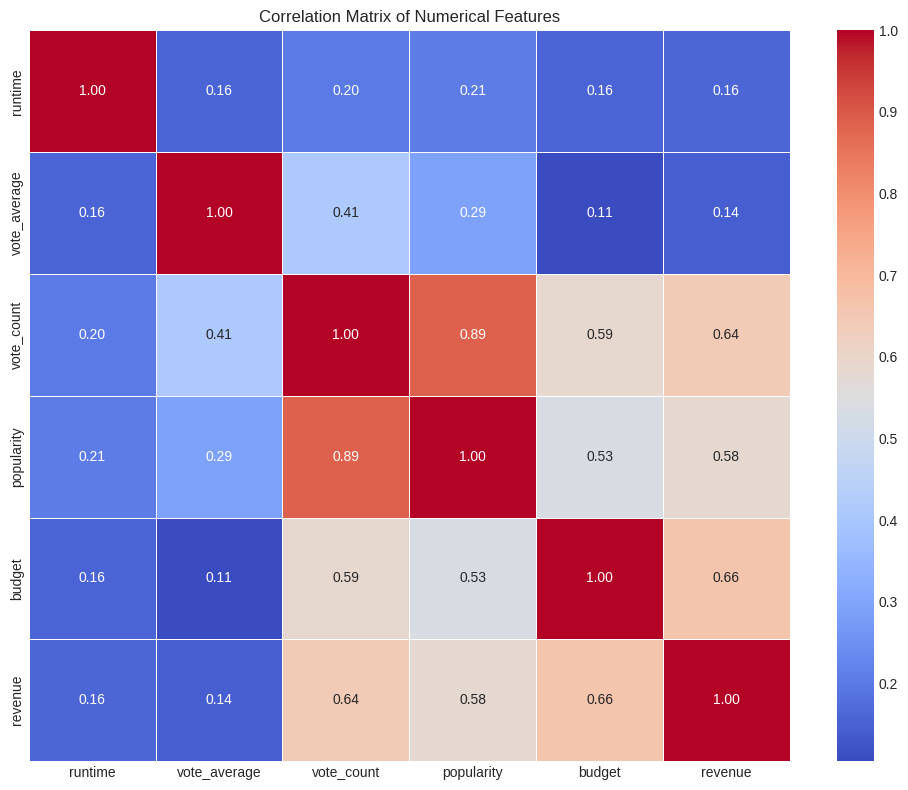

In [ ]:
numerical_features_for_corr = ['runtime', 'vote_average', 'vote_count', 'popularity', 'budget', 'revenue']
numerical_features_for_corr_actual = []

for col in numerical_features_for_corr:
    if col in full_movies_df.columns and pd.api.types.is_numeric_dtype(full_movies_df[col]):
        # Check if the column has enough non-NaN values for correlation
        if full_movies_df[col].dropna().nunique() > 1: # Must have at least 2 unique values
            numerical_features_for_corr_actual.append(col)
        else:
            print(f"Skipping correlation for '{col}': not enough unique numerical values or all NaN.")

if numerical_features_for_corr_actual:
    # Create a copy to avoid SettingWithCopyWarning when transforming for correlation
    correlation_df_prep = full_movies_df[numerical_features_for_corr_actual].copy()

    # Log transform vote_count, popularity, budget, revenue for better correlation visualization if skewed
    # Replace 0s with NaN for budget/revenue before correlation to avoid skewing (as 0 might mean unknown)
    for col_to_transform in ['vote_count', 'popularity', 'budget', 'revenue']:
        if col_to_transform in correlation_df_prep.columns:
            if col_to_transform in ['budget', 'revenue']:
                correlation_df_prep[col_to_transform] = correlation_df_prep[col_to_transform].replace(0, np.nan)
            correlation_df_prep[col_to_transform] = np.log1p(correlation_df_prep[col_to_transform].fillna(0)) # Fillna(0) for log1p before correlation calc

    correlation_matrix = correlation_df_prep.corr(numeric_only=True) # Ensure only numeric columns are used for corr

    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title('Correlation Matrix of Numerical Features')
    plt.tight_layout()
    plt.show()
else:
    print("No numerical features available for correlation analysis.")

In [ ]:
full_movies_df.columns

Index(['tmdb_id', 'title', 'plot_description', 'adult', 'tagline',
       'crew_text_features', 'cast_text_features', 'original_language',
       'runtime', 'vote_average', 'vote_count', 'release_date', 'popularity',
       'budget', 'revenue', 'Poster_available', 'poster_byte', 'avg_rgb_color',
       'genres_parsed', 'directors_parsed', 'writer_parsed', 'composer_parsed',
       'cinematographer_parsed', 'editor_parsed', 'productiondesigner_parsed',
       'artdirector_parsed', 'main_actors_parsed', 'release_date_dt',
       'release_year', 'primary_genre'],
      dtype='object')